In [1]:
import akshare as ak
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import talib
import numpy as np
from matplotlib.font_manager import FontProperties
import os
import mplfinance as mpf 
import importlib
import utils
importlib.reload(utils)

%matplotlib inline
# 添加字体
matplotlib.rcParams['axes.unicode_minus']=False # 如果不加入下面这一句，会导致负号无法显示
plt.rcParams["font.sans-serif"] = ["SimHei"]

# 思路

参考这个:https://www.bilibili.com/video/BV1d5411P7Lt/


# 获得上证指数
指数代码：https://q.stock.sohu.com/cn/zs.shtml

- SH000001: 上证指数
- SH000300: 沪深300
- SH000016：上证50
- SH000905：中证500
- SH000906：中证800
- SH000852：中证1000

In [2]:
index_code = "sh000905"
index_file = f"{index_code}.csv"
df_stock_index = ak.stock_zh_index_daily(symbol=index_code)
print(df_stock_index)

            date      open      high       low     close       volume
0     2005-01-04   996.682   996.682   984.795   986.927    232376203
1     2005-01-05   986.570  1008.855   985.677  1003.633    348610113
2     2005-01-06  1003.490  1003.490   990.792   994.595    293390559
3     2005-01-07   993.434  1009.000   990.446   997.606    339162698
4     2005-01-10   996.928  1006.457   993.123  1006.337    294940533
...          ...       ...       ...       ...       ...          ...
4351  2022-11-30  6156.772  6175.682  6118.902  6156.147  15464797200
4352  2022-12-01  6211.291  6229.834  6186.102  6186.102  15252332500
4353  2022-12-02  6177.923  6206.986  6154.209  6168.013  11550097500
4354  2022-12-05  6201.980  6227.214  6182.976  6215.124  17047721100
4355  2022-12-06  6202.524  6244.638  6185.494  6211.252  14937281500

[4356 rows x 6 columns]


      Unnamed: 0       date      open      high       low     close  \
0              0 2005-01-04   996.682   996.682   984.795   986.927   
1              1 2005-01-05   986.570  1008.855   985.677  1003.633   
2              2 2005-01-06  1003.490  1003.490   990.792   994.595   
3              3 2005-01-07   993.434  1009.000   990.446   997.606   
4              4 2005-01-10   996.928  1006.457   993.123  1006.337   
...          ...        ...       ...       ...       ...       ...   
4343        4343 2022-11-18  6213.091  6251.107  6181.554  6191.648   
4344        4344 2022-11-21  6147.717  6196.647  6116.296  6189.709   
4345        4345 2022-11-22  6178.163  6196.196  6100.113  6125.400   
4346        4346 2022-11-23  6114.269  6140.114  6045.024  6115.605   
4347        4347 2022-11-24  6126.598  6149.960  6099.750  6120.066   

           volume  
0       232376203  
1       348610113  
2       293390559  
3       339162698  
4       294940533  
...           ...  
4343  1

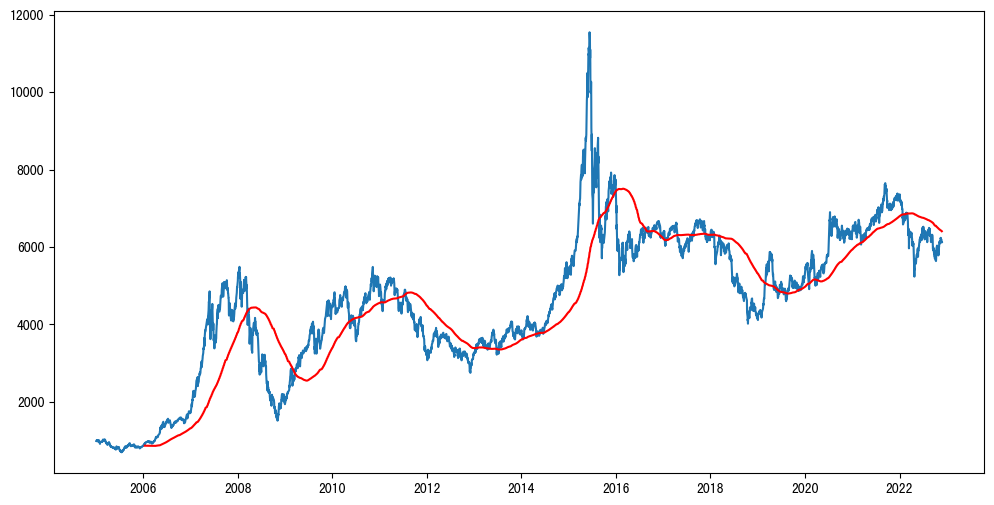

In [3]:
# 上证指数: 
# https://www.akshare.xyz/data/index/index.html#id1

index_code = "sh000905"
index_file = f"{index_code}.csv"
if not os.path.exists(index_file):
    df_stock_index = ak.stock_zh_index_daily(symbol=index_code)
    df_stock_index.to_csv(index_file)
else:
    df_stock_index = pd.read_csv(index_file)
    df_stock_index['date'] = pd.to_datetime(df_stock_index['date'], format='%Y-%m-%d')
print(df_stock_index)


df_stock_index['ma'] = talib.SMA(df_stock_index.close, timeperiod=250)

plt.figure(figsize=(12,6))
plt.plot(df_stock_index.date,df_stock_index.close)
plt.plot(df_stock_index.date,df_stock_index.ma,color='r')

# 获得某只基金的累计净值

开放式基金-历史数据
接口: fund_open_fund_info_em
https://akshare.akfamily.xyz/data/fund/fund_public.html#id6

      Unnamed: 0       净值日期    累计净值     ma242
0              0 2013-02-06  1.0000       NaN
1              1 2013-02-08  1.0022       NaN
2              2 2013-02-22  0.9954       NaN
3              3 2013-03-01  1.0135       NaN
4              4 2013-03-08  0.9980       NaN
...          ...        ...     ...       ...
2373        2373 2022-11-29  1.9829  2.023717
2374        2374 2022-11-30  1.9804  2.022425
2375        2375 2022-12-01  1.9906  2.021231
2376        2376 2022-12-02  1.9853  2.019922
2377        2377 2022-12-05  1.9995  2.018751

[2378 rows x 4 columns]


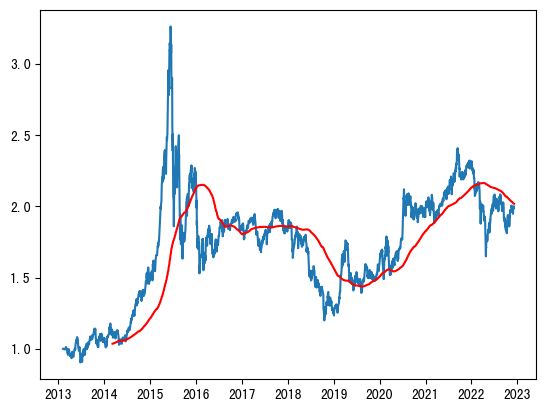

In [4]:
fund_code = "510500" # 中证500ETF

fund_file = f"{fund_code}.csv"

if not os.path.exists(f"{fund_code}.csv"):
    df_fund = ak.fund_open_fund_info_em(fund=fund_code, indicator="累计净值走势")
    df_fund.to_csv(fund_file)
else:
    df_fund = pd.read_csv(fund_file)
    df_fund['净值日期'] = pd.to_datetime(df_fund['净值日期'], format='%Y-%m-%d')

df_fund['ma242'] = talib.SMA(df_fund['累计净值'], timeperiod=242)
print(df_fund)
plt.plot(df_fund['净值日期'],df_fund['累计净值'])
plt.plot(df_fund['净值日期'],df_fund.ma242,color='r')

In [6]:
df_fund = df_fund.rename(columns={'净值日期':'date','累计净值':'close'})
df_fund = df_fund.set_index("date")
df_fund['_diff'] = df_fund.close - df_fund.ma242
# 乖离率
df_fund['diff_percent'] = df_fund._diff/df_fund.ma242
# 生成每隔5%的分位数，
print(df_fund[df_fund.diff_percent>0].diff_percent.describe(percentiles=np.linspace(0,1,11)))
print(df_fund[df_fund.diff_percent<0].diff_percent.describe(percentiles=np.linspace(0,1,11)))
# df_fund.diff_percent.plot()

count    1334.000000
mean        0.121352
std         0.155693
min         0.000075
0%          0.000075
10%         0.014961
20%         0.027327
30%         0.039615
40%         0.053156
50%         0.067909
60%         0.087456
70%         0.112893
80%         0.186523
90%         0.261805
100%        0.961931
max         0.961931
Name: diff_percent, dtype: float64
count    803.000000
mean      -0.092765
std        0.073387
min       -0.290354
0%        -0.290354
10%       -0.193720
20%       -0.170402
30%       -0.147326
40%       -0.101380
50%       -0.071004
60%       -0.050113
70%       -0.034102
80%       -0.020986
90%       -0.009879
100%      -0.000268
max       -0.000268
Name: diff_percent, dtype: float64
